In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from math import pi
from matplotlib.path import Path
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

In [2]:
constant_patch = '11.23.1'

# 라이엇 개발자 페이지에서 최신 버전 한국 서버 챔피언 정보 가져오기
champion_info = requests.get("http://ddragon.leagueoflegends.com/cdn/" + constant_patch + "/data/ko_KR/champion.json").json()   

In [3]:
# 챔피언 정보 => DataFrame으로 변환
# champion_df는 'key'로 id값, 'name'으로 챔피언 한국어 이름을 가지는 156rows짜리 DataFrame
champion_df = pd.DataFrame(champion_info['data']).T[['key', 'name']]

# champion_df의 'key' column string => numeric 변환
champion_df['key'] = pd.to_numeric(champion_df['key'])

In [4]:
df = pd.read_csv('11.23.csv', index_col=0)

C:\Users\power\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [5]:
df = df.merge(champion_df, how = 'left', left_on = 'championId', right_on = 'key')

In [6]:
data = pd.DataFrame()
data = df[['tierRank', 'position', 'name', 'result']]

In [7]:
# 결측치 드랍
data = data.dropna(axis=0)
# 다시하기 드랍
data.drop(data.loc[data['result']=='UNKNOWN'].index, inplace=True)
print('data : ', len(data))

data :  5065150


In [8]:
# result 숫자로 변환
data.loc[data['result'] == 'WIN', 'result'] = 1
data.loc[data['result'] == 'LOSE', 'result'] = 0
data['games'] = 1
data = data.astype({'result' : 'int'})
# result -> wins로 컬럼명 변경
data.rename(columns = {'result':'wins'},inplace=True)

In [9]:
# 티어별 데이터 프레임 생성
TierList = ['IRON', 'BRONZE', 'SILVER', 'GOLD', 'PLATINUM', 'DIAMOND',
        'MASTER', 'GRAND_MASTER','CHALLENGER']
TierFront = ['I', 'B', 'S', 'G', 'P', 'D', 'M', 'G', 'C']

for i, j in zip(TierList, TierFront) :
    globals()[f'{i}'] = data[data['tierRank'].str.contains(f'{j}')]

low_list = ['I', 'B', 'S', 'G']
low_list = '|'.join(low_list)
LOW_TIER = data[data['tierRank'].str.contains(low_list)]
mid_list = ['P', 'D']
mid_list = '|'.join(mid_list)
MID_TIER = data[data['tierRank'].str.contains(mid_list)]
high_list = ['M', 'R', 'C']
high_list = '|'.join(high_list)
HIGH_TIER = data[data['tierRank'].str.contains(high_list)]

#print('SUM : ', len(IRON)+len(BRONZE)+len(SILVER)+len(GOLD)+len(PLATINUM)+len(DIAMOND)+len(HIGH_TIER))
#print('SUM : ', len(LOW_TIER)+len(MID_TIER)+len(HIGH_TIER))

In [10]:
# 티어별-포지션별 승률, 픽률
LOW_TIER_total = LOW_TIER.groupby(['position', 'name'], as_index=False).sum()
LOW_TIER_sum = LOW_TIER.groupby(['position'], as_index=False).sum()
LOW_TIER_sum.columns = ['position', 'wins', 'total_games']
LOW_TIER_sum = LOW_TIER_sum[['position', 'total_games']]
LOW_TIER_total = LOW_TIER_total.merge(LOW_TIER_sum, how = 'left', on = 'position')
LOW_TIER_total = LOW_TIER_total[LOW_TIER_total.games > 50]
LOW_TIER_total['winRate'] = LOW_TIER_total['wins'] / LOW_TIER_total['games']
LOW_TIER_total['pickRate'] = LOW_TIER_total['games'] / LOW_TIER_total['total_games']
LOW_TIER_total = LOW_TIER_total.sort_values(by=['position', 'winRate', 'pickRate'], ascending=False) 

MID_TIER_total = MID_TIER.groupby(['position', 'name'], as_index=False).sum()
MID_TIER_sum = MID_TIER.groupby(['position'], as_index=False).sum()
MID_TIER_sum.columns = ['position', 'wins', 'total_games']
MID_TIER_sum = MID_TIER_sum[['position', 'total_games']]
MID_TIER_total = MID_TIER_total.merge(MID_TIER_sum, how = 'left', on = 'position')
MID_TIER_total = MID_TIER_total[MID_TIER_total.games > 50]
MID_TIER_total['winRate'] = MID_TIER_total['wins'] / MID_TIER_total['games']
MID_TIER_total['pickRate'] = MID_TIER_total['games'] / MID_TIER_total['total_games']
MID_TIER_total = MID_TIER_total.sort_values(by=['position', 'winRate', 'pickRate'], ascending=False) 

HIGH_TIER_total = HIGH_TIER.groupby(['position', 'name'], as_index=False).sum()
HIGH_TIER_sum = HIGH_TIER.groupby(['position'], as_index=False).sum()
HIGH_TIER_sum.columns = ['position', 'wins', 'total_games']
HIGH_TIER_sum = HIGH_TIER_sum[['position', 'total_games']]
HIGH_TIER_total = HIGH_TIER_total.merge(HIGH_TIER_sum, how = 'left', on = 'position')
HIGH_TIER_total = HIGH_TIER_total[HIGH_TIER_total.games > 50]
HIGH_TIER_total['winRate'] = HIGH_TIER_total['wins'] / HIGH_TIER_total['games']
HIGH_TIER_total['pickRate'] = HIGH_TIER_total['games'] / HIGH_TIER_total['total_games']
HIGH_TIER_total = HIGH_TIER_total.sort_values(by=['position', 'winRate', 'pickRate'], ascending=False) 

In [11]:
P = ['T','J', 'M','A','S']
line = ['TOP', 'JUG', 'MID', 'AD', 'SUP']
tier = ['LOW_TIER', 'MID_TIER', 'HIGH_TIER']
#tier = ['IRON', 'BRONZE', 'SILVER', 'GOLD', 'PLATINUM', 'DIAMOND', 'MASTER', 'GRAND_MASTER','CHALLENGER', 'ABOVE_MASTER']
for i in tier:
    for j, k in zip(line, P):
        a = globals()[f'{i}_total']
        globals()[f'{i}_{j}'] = a[a['position'] == f'{k}'].sort_values(by=['pickRate'], ascending=False).head(5)

In [12]:
HIGH_TIER_AD

,position,name,wins,games,total_games,winRate,pickRate
48,A,진,508,1038,6049,0.489403,0.171599
49,A,징크스,444,854,6049,0.519906,0.141180
32,A,아펠리오스,346,724,6049,0.477901,0.119689
57,A,케이틀린,232,478,6049,0.485356,0.079021
39,A,이즈리얼,213,442,6049,0.481900,0.073070


In [13]:
data = pd.read_csv('json_champ.csv', index_col=0)

In [1]:
data.iloc[]

NameError: name 'data' is not defined

In [14]:
json_champ = data.merge(champion_df, how = 'left', left_on = 'championId', right_on = 'key')

In [15]:
json_champ['name_x'] = json_champ['name_y']

In [16]:
json_champ = json_champ.iloc[:,0:11]

In [17]:
pd.set_option('display.max_rows', None)
json_champ

,name_x,style,difficulty,damageType,damage,durability,crowdControl,mobility,utility,roles,key
0,그웬,5,2,kMagic,3,2,1,3,1,"['fighter', 'assassin']",887
1,릴리아,8,3,kMagic,3,1,2,2,2,"['fighter', 'mage']",876
2,세트,4,2,kPhysical,2,2,2,2,1,"['fighter', 'tank']",875
3,요네,5,3,kMixed,3,1,2,3,1,"['assassin', 'fighter']",777
4,벡스,9,2,kMagic,3,2,2,2,1,['mage'],711
5,파이크,7,2,kPhysical,2,1,3,3,1,"['support', 'assassin']",555
6,렐,9,2,kMagic,1,3,3,2,2,['tank'],526
7,아펠리오스,3,3,kPhysical,3,1,2,1,1,['marksman'],523
8,니코,8,1,kMagic,3,1,3,1,1,"['mage', 'support']",518
9,사일러스,7,3,kMagic,2,2,1,3,1,"['mage', 'assassin']",517


In [18]:
line = ['TOP', 'JUG', 'MID', 'AD', 'SUP']
tier = ['LOW_TIER', 'MID_TIER', 'HIGH_TIER']
#tier = ['IRON', 'BRONZE', 'SILVER', 'GOLD', 'PLATINUM', 'DIAMOND', 'MASTER', 'GRAND_MASTER','CHALLENGER', 'ABOVE_MASTER']
for j in line:
    for i in tier:
        globals()[f'{i}_{j}'] = globals()[f'{i}_{j}'].merge(json_champ, how = 'left', left_on = 'name', right_on = 'name_x')

In [19]:
HIGH_TIER_AD

,position,name,wins,games,total_games,winRate,pickRate,name_x,style,difficulty,damageType,damage,durability,crowdControl,mobility,utility,roles,key
0,A,진,508,1038,6049,0.489403,0.171599,진,3,2,kPhysical,3,1,2,1,1,"['marksman', 'mage']",202
1,A,징크스,444,854,6049,0.519906,0.141180,징크스,2,2,kPhysical,3,1,2,1,1,['marksman'],222
2,A,아펠리오스,346,724,6049,0.477901,0.119689,아펠리오스,3,3,kPhysical,3,1,2,1,1,['marksman'],523
3,A,케이틀린,232,478,6049,0.485356,0.079021,케이틀린,2,1,kPhysical,3,1,2,2,1,['marksman'],51
4,A,이즈리얼,213,442,6049,0.481900,0.073070,이즈리얼,1,1,kMagic,1,1,1,1,1,"['marksman', 'mage']",81


In [20]:
line = ['TOP', 'JUG', 'MID', 'AD', 'SUP']
tier = ['LOW_TIER', 'MID_TIER', 'HIGH_TIER']
#tier = ['IRON', 'BRONZE', 'SILVER', 'GOLD', 'PLATINUM', 'DIAMOND', 'MASTER', 'GRAND_MASTER','CHALLENGER', 'ABOVE_MASTER']
for j in line:
    for i in tier:
        globals()[f'{i}_{j}_mean'] = globals()[f'{i}_{j}'].mean()[5:12]

In [21]:
# LOW_TIER_AD_mean

In [22]:
# line = ['TOP', 'JUG', 'MID', 'AD', 'SUP']
# tier = ['LOW_TIER', 'MID_TIER', 'HIGH_TIER']
# #tier = ['IRON', 'BRONZE', 'SILVER', 'GOLD', 'PLATINUM', 'DIAMOND','MASTER', 'GRAND_MASTER','CHALLENGER', 'ABOVE_MASTER']

# for i in tier : 
#     for j in line :
#         aa = globals()[f'{i}_{j}_mean']
#         globals()[f'{i}_{j}_stats'] = [aa[0], aa[1], aa[2], aa[3], aa[4]]

In [23]:
columns = ['damage', 'durability', 'crowdControl', 'mobility', 'utility']

In [24]:
line = ['TOP', 'JUG', 'MID', 'AD', 'SUP']
tier = ['LOW_TIER', 'MID_TIER', 'HIGH_TIER']

for i in tier :
    for j in line :
        a = globals()[f'{i}_{j}_mean']
        globals()[f'{i}_{j}'] = pd.DataFrame(a).T
        globals()[f'{i}_{j}'] = globals()[f'{i}_{j}'][columns]

In [25]:
tier = ['LOW_TIER', 'MID_TIER', 'HIGH_TIER']
line = ['TOP', 'JUG', 'MID', 'AD', 'SUP']

TOP = pd.concat([LOW_TIER_TOP, MID_TIER_TOP, HIGH_TIER_TOP], ignore_index=True)
TOP.insert(0, 'tier', tier)

JUG = pd.concat([LOW_TIER_JUG, MID_TIER_JUG, HIGH_TIER_JUG], ignore_index=True)
JUG.insert(0, 'tier', tier)

MID = pd.concat([LOW_TIER_MID, MID_TIER_MID, HIGH_TIER_MID], ignore_index=True)
MID.insert(0, 'tier', tier)

AD = pd.concat([LOW_TIER_AD, MID_TIER_AD, HIGH_TIER_AD], ignore_index=True)
AD.insert(0, 'tier', tier)

SUP = pd.concat([LOW_TIER_SUP, MID_TIER_SUP, HIGH_TIER_SUP], ignore_index=True)
SUP.insert(0, 'tier', tier)

In [26]:
TOP

,tier,damage,durability,crowdControl,mobility,utility
0,LOW_TIER,2.8,1.6,1.8,1.8,1.4
1,MID_TIER,2.8,1.8,1.8,2.2,1.6
2,HIGH_TIER,2.6,1.8,1.8,2.4,1.4


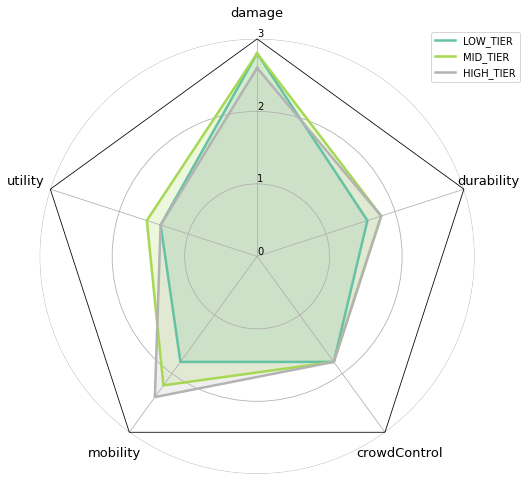

In [28]:
#TOP_stats_by_tier
labels = TOP.columns[1:]
num_labels = len(labels)
    
angles = [x / float(num_labels) * (2 * pi) for x in range(num_labels)] 
angles += angles[:1] 
    
my_palette = plt.cm.get_cmap("Set2", len(TOP.index))
 
fig = plt.figure(figsize=(8, 8))
fig.set_facecolor('white')
ax = fig.add_subplot(polar = True)
for i, row in TOP.iterrows():
    color = my_palette(i)
    data = TOP.iloc[i].drop('tier').tolist()
    data += data[:1]
    
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    
    plt.xticks(angles[: -1], labels, fontsize = 13)
    ax.tick_params(axis='x', which='major', pad = 15)
    
    ax.set_rlabel_position(0)
    plt.yticks([0, 1, 2, 3],['0', '1', '2', '3'], fontsize=10)
    plt.ylim(0, 3)
    
    ax.plot(angles, data, color = color, linewidth = 2.5, linestyle = 'solid', label = row.tier)
    ax.fill(angles, data, color = color, alpha = 0.2)
    
for g in ax.yaxis.get_gridlines() :
    g.get_path()._interpolation_steps = len(labels)
 
spine = Spine(axes = ax,
          spine_type = 'circle',
          path = Path.unit_regular_polygon(len(labels)))

spine.set_transform(Affine2D().scale(.5).translate(.5, .5) + ax.transAxes)
           
ax.spines = {'polar' : spine} 

plt.legend(loc=(0.9, 0.9))
plt.show()

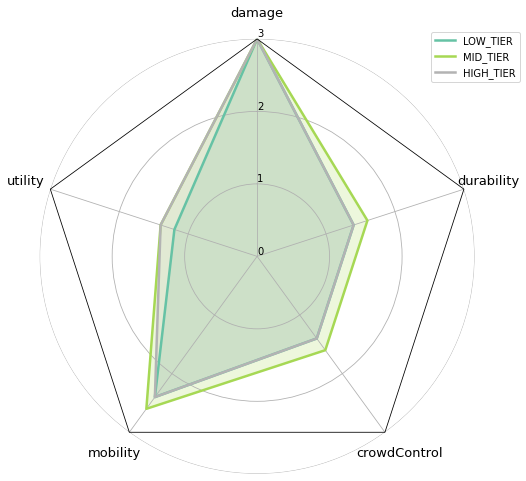

In [32]:
#JUG_stats_by_tier
labels = JUG.columns[1:]
num_labels = len(labels)
    
angles = [x / float(num_labels) * (2 * pi) for x in range(num_labels)] 
angles += angles[:1] 
    
my_palette = plt.cm.get_cmap("Set2", len(JUG.index))
 
fig = plt.figure(figsize=(8, 8))
fig.set_facecolor('white')
ax = fig.add_subplot(polar = True)
for i, row in JUG.iterrows():
    color = my_palette(i)
    data = JUG.iloc[i].drop('tier').tolist()
    data += data[:1]
    
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    
    plt.xticks(angles[: -1], labels, fontsize = 13)
    ax.tick_params(axis='x', which='major', pad = 15)
    
    ax.set_rlabel_position(0)
    plt.yticks([0, 1, 2, 3],['0', '1', '2', '3'], fontsize=10)
    plt.ylim(0, 3)
    
    ax.plot(angles, data, color = color, linewidth = 2.5, linestyle = 'solid', label = row.tier)
    ax.fill(angles, data, color = color, alpha = 0.2)
    
for g in ax.yaxis.get_gridlines() :
    g.get_path()._interpolation_steps = len(labels)
 
spine = Spine(axes = ax,
          spine_type = 'circle',
          path = Path.unit_regular_polygon(len(labels)))

spine.set_transform(Affine2D().scale(.5).translate(.5, .5) + ax.transAxes)
           
ax.spines = {'polar' : spine} 

plt.legend(loc=(0.9, 0.9))
plt.show()

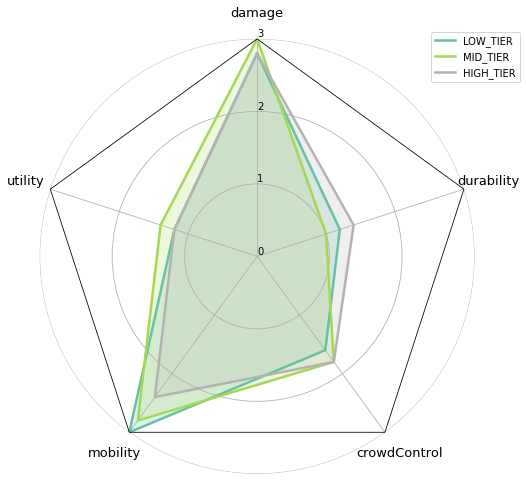

In [31]:
#MID_stats_by_tier
labels = MID.columns[1:]
num_labels = len(labels)
    
angles = [x / float(num_labels) * (2 * pi) for x in range(num_labels)] 
angles += angles[:1] 
    
my_palette = plt.cm.get_cmap("Set2", len(MID.index))
 
fig = plt.figure(figsize=(8, 8))
fig.set_facecolor('white')
ax = fig.add_subplot(polar = True)
for i, row in MID.iterrows():
    color = my_palette(i)
    data = MID.iloc[i].drop('tier').tolist()
    data += data[:1]
    
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    
    plt.xticks(angles[: -1], labels, fontsize = 13)
    ax.tick_params(axis='x', which='major', pad = 15)
    
    ax.set_rlabel_position(0)
    plt.yticks([0, 1, 2, 3],['0', '1', '2', '3'], fontsize=10)
    plt.ylim(0, 3)
    
    ax.plot(angles, data, color = color, linewidth = 2.5, linestyle = 'solid', label = row.tier)
    ax.fill(angles, data, color = color, alpha = 0.2)
    
for g in ax.yaxis.get_gridlines() :
    g.get_path()._interpolation_steps = len(labels)
 
spine = Spine(axes = ax,
          spine_type = 'circle',
          path = Path.unit_regular_polygon(len(labels)))

spine.set_transform(Affine2D().scale(.5).translate(.5, .5) + ax.transAxes)
           
ax.spines = {'polar' : spine} 

plt.legend(loc=(0.9, 0.9))
plt.show()

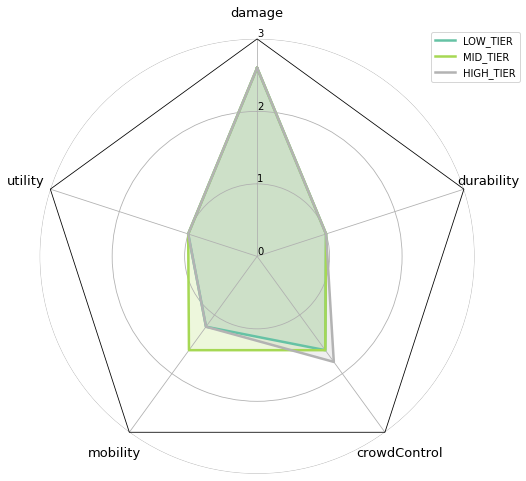

In [30]:
#AD_stats_by_tier
labels = AD.columns[1:]
num_labels = len(labels)
    
angles = [x / float(num_labels) * (2 * pi) for x in range(num_labels)] 
angles += angles[:1] 
    
my_palette = plt.cm.get_cmap("Set2", len(AD.index))
 
fig = plt.figure(figsize=(8, 8))
fig.set_facecolor('white')
ax = fig.add_subplot(polar = True)
for i, row in AD.iterrows():
    color = my_palette(i)
    data = AD.iloc[i].drop('tier').tolist()
    data += data[:1]
    
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    
    plt.xticks(angles[: -1], labels, fontsize = 13)
    ax.tick_params(axis='x', which='major', pad = 15)
    
    ax.set_rlabel_position(0)
    plt.yticks([0, 1, 2, 3],['0', '1', '2', '3'], fontsize=10)
    plt.ylim(0, 3)
    
    ax.plot(angles, data, color = color, linewidth = 2.5, linestyle = 'solid', label = row.tier)
    ax.fill(angles, data, color = color, alpha = 0.2)
    
for g in ax.yaxis.get_gridlines() :
    g.get_path()._interpolation_steps = len(labels)
 
spine = Spine(axes = ax,
          spine_type = 'circle',
          path = Path.unit_regular_polygon(len(labels)))

spine.set_transform(Affine2D().scale(.5).translate(.5, .5) + ax.transAxes)
           
ax.spines = {'polar' : spine} 

plt.legend(loc=(0.9, 0.9))
plt.show()

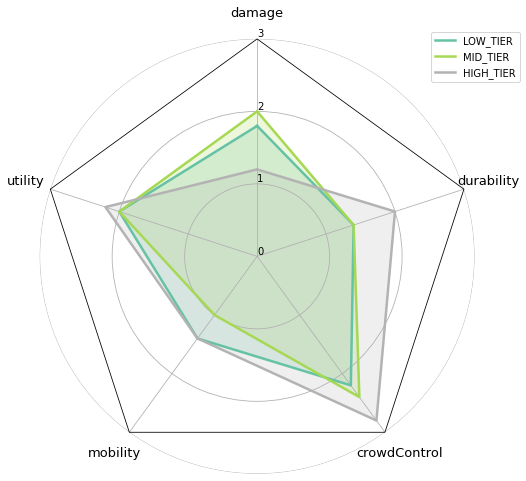

In [29]:
#SUP_stats_by_tier
labels = SUP.columns[1:]
num_labels = len(labels)
    
angles = [x / float(num_labels) * (2 * pi) for x in range(num_labels)] 
angles += angles[:1] 
    
my_palette = plt.cm.get_cmap("Set2", len(SUP.index))
 
fig = plt.figure(figsize=(8, 8))
fig.set_facecolor('white')
ax = fig.add_subplot(polar = True)
for i, row in SUP.iterrows():
    color = my_palette(i)
    data = SUP.iloc[i].drop('tier').tolist()
    data += data[:1]
    
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    
    plt.xticks(angles[: -1], labels, fontsize = 13)
    ax.tick_params(axis='x', which='major', pad = 15)
    
    ax.set_rlabel_position(0)
    plt.yticks([0, 1, 2, 3],['0', '1', '2', '3'], fontsize=10)
    plt.ylim(0, 3)
    
    ax.plot(angles, data, color = color, linewidth = 2.5, linestyle = 'solid', label = row.tier)
    ax.fill(angles, data, color = color, alpha = 0.2)
    
for g in ax.yaxis.get_gridlines() :
    g.get_path()._interpolation_steps = len(labels)
 
spine = Spine(axes = ax,
          spine_type = 'circle',
          path = Path.unit_regular_polygon(len(labels)))

spine.set_transform(Affine2D().scale(.5).translate(.5, .5) + ax.transAxes)
           
ax.spines = {'polar' : spine} 

plt.legend(loc=(0.9, 0.9))
plt.show()

In [ ]:
# LOW_TIER_TOP_mean

In [ ]:
# # Top stats by tier
# categories = ['damage', 'durability', 'crowdControl', 'mobility', 'utility']
# categories = [*categories, categories[0]]

# LOW_TIER_TOP_stats = [*LOW_TIER_TOP_stats, LOW_TIER_TOP_stats[0]]
# MID_TIER_TOP_stats = [*MID_TIER_TOP_stats, MID_TIER_TOP_stats[0]]
# HIGH_TIER_TOP_stats = [*HIGH_TIER_TOP_stats, HIGH_TIER_TOP_stats[0]]

# label_loc = np.linspace(start = 0, stop = 2*np.pi, num = len(LOW_TIER_TOP_stats))


# plt.figure(figsize = (8, 8))
# ax = plt.subplot(polar = True)
# plt.xticks(label_loc, labels = categories, fontsize = 13)
# plt.ylim(1, 3)
# ax.plot(label_loc, LOW_TIER_TOP_stats, label = 'LOW_TIER_TOP', linestyle = 'dashed', color = 'red')
# ax.fill(label_loc, LOW_TIER_TOP_stats, 'red', alpha = 1)
# ax.plot(label_loc, MID_TIER_TOP_stats, label = 'MID_TIER_TOP', linestyle = 'dashed', color = 'green')
# ax.fill(label_loc, MID_TIER_TOP_stats, 'green', alpha = 1)
# ax.plot(label_loc, HIGH_TIER_TOP_stats, label = 'HIGH_TIER_TOP', linestyle = 'dashed', color = 'skyblue')
# ax.fill(label_loc, HIGH_TIER_TOP_stats, 'skyblue', alpha = 1)

# ax.legend()
# #ax.show()

In [ ]:
# # JG stats by tier
# categories = ['damage', 'durability', 'crowdControl', 'mobility', 'utility']
# categories = [*categories, categories[0]]

# LOW_TIER_JUG_stats = [*LOW_TIER_JUG_stats, LOW_TIER_JUG_stats[0]]
# MID_TIER_JUG_stats = [*MID_TIER_JUG_stats, MID_TIER_JUG_stats[0]]
# HIGH_TIER_JUG_stats = [*HIGH_TIER_JUG_stats, HIGH_TIER_JUG_stats[0]]

# label_loc = np.linspace(start = 0, stop = 2*np.pi, num = len(LOW_TIER_JUG_stats))

# plt.figure(figsize = (8, 8))
# ax = plt.subplot(polar = True)
# plt.xticks(label_loc, labels = categories, fontsize = 13)
# plt.ylim(0, 3.2)
# ax.plot(label_loc, LOW_TIER_JUG_stats, label = 'LOW_TIER_JUG', linestyle = 'dashed', color = 'lightcoral')
# ax.fill(label_loc, LOW_TIER_JUG_stats, 'lightcoral', alpha = 0.4)
# ax.plot(label_loc, MID_TIER_JUG_stats, label = 'MID_TIER_JUG', linestyle = 'dashed', color = 'violet')
# ax.fill(label_loc, MID_TIER_JUG_stats, 'violet', alpha = 0.4)
# ax.plot(label_loc, HIGH_TIER_JUG_stats, label = 'HIGH_TIER_JUG_stats', linestyle = 'dashed', color = 'skyblue')
# ax.fill(label_loc, HIGH_TIER_JUG_stats, 'skyblue', alpha = 0.4)

# ax.legend()
# #ax.show()

In [ ]:
# # MID stats by tier
# categories = ['damage', 'durability', 'crowdControl', 'mobility', 'utility']
# categories = [*categories, categories[0]]

# LOW_TIER_MID_stats = [*LOW_TIER_MID_stats, LOW_TIER_MID_stats[0]]
# MID_TIER_MID_stats = [*MID_TIER_MID_stats, MID_TIER_MID_stats[0]]
# HIGH_TIER_MID_stats = [*HIGH_TIER_MID_stats, HIGH_TIER_MID_stats[0]]

# label_loc = np.linspace(start = 0, stop = 2*np.pi, num = len(LOW_TIER_MID_stats))

# plt.figure(figsize = (8, 8))
# ax = plt.subplot(polar = True)
# plt.xticks(label_loc, labels = categories, fontsize = 13)
# plt.ylim(0, 3.2)
# ax.plot(label_loc, LOW_TIER_MID_stats, label = 'LOW_TIER_MID', linestyle = 'dashed', color = 'lightcoral')
# ax.fill(label_loc, LOW_TIER_MID_stats, 'lightcoral', alpha = 0.4)
# ax.plot(label_loc, MID_TIER_MID_stats, label = 'MID_TIER_MID', linestyle = 'dashed', color = 'violet')
# ax.fill(label_loc, MID_TIER_MID_stats, 'violet', alpha = 0.4)
# ax.plot(label_loc, HIGH_TIER_MID_stats, label = 'HIGH_TIER_MID', linestyle = 'dashed', color = 'skyblue')
# ax.fill(label_loc, HIGH_TIER_MID_stats, 'skyblue', alpha = 0.4)

# ax.legend()
# #ax.show()

In [ ]:
# # AD stats by tier
# categories = ['damage', 'durability', 'crowdControl', 'mobility', 'utility']
# categories = [*categories, categories[0]]

# LOW_TIER_AD_stats = [*LOW_TIER_AD_stats, LOW_TIER_AD_stats[0]]
# MID_TIER_AD_stats = [*MID_TIER_AD_stats, MID_TIER_AD_stats[0]]
# HIGH_TIER_AD_stats = [*HIGH_TIER_AD_stats, HIGH_TIER_AD_stats[0]]

# label_loc = np.linspace(start = 0, stop = 2*np.pi, num = len(LOW_TIER_AD_stats))

# plt.figure(figsize = (8, 8))
# ax = plt.subplot(polar = True)
# plt.xticks(label_loc, labels = categories, fontsize = 13)
# plt.ylim(0, 3)
# ax.plot(label_loc, LOW_TIER_AD_stats, label = 'LOW_TIER_AD', linestyle = 'dashed', color = 'lightcoral')
# ax.fill(label_loc, LOW_TIER_AD_stats, 'lightcoral', alpha = 0.4)
# ax.plot(label_loc, MID_TIER_AD_stats, label = 'MID_TIER_AD', linestyle = 'dashed', color = 'violet')
# ax.fill(label_loc, MID_TIER_AD_stats, 'violet', alpha = 0.4)
# ax.plot(label_loc, HIGH_TIER_AD_stats, label = 'HIGH_TIER_AD', linestyle = 'dashed', color = 'skyblue')
# ax.fill(label_loc, HIGH_TIER_AD_stats, 'skyblue', alpha = 0.4)

# ax.legend()
# #ax.show()

In [ ]:
# # SUP stats by tier
# categories = ['damage', 'durability', 'crowdControl', 'mobility', 'utility']
# categories = [*categories, categories[0]]

# LOW_TIER_SUP_stats = [*LOW_TIER_SUP_stats, LOW_TIER_SUP_stats[0]]
# MID_TIER_SUP_stats = [*MID_TIER_SUP_stats, MID_TIER_SUP_stats[0]]
# HIGH_TIER_SUP_stats = [*HIGH_TIER_SUP_stats, HIGH_TIER_SUP_stats[0]]

# label_loc = np.linspace(start = 0, stop = 2*np.pi, num = len(LOW_TIER_SUP_stats))

# plt.figure(figsize = (8, 8))
# ax = plt.subplot(polar = True)
# plt.xticks(label_loc, labels = categories, fontsize = 13)
# plt.ylim(0, 3)
# ax.plot(label_loc, LOW_TIER_SUP_stats, label = 'LOW_TIER_SUP', linestyle = 'dashed', color = 'lightcoral')
# ax.fill(label_loc, LOW_TIER_SUP_stats, 'lightcoral', alpha = 0.4)
# ax.plot(label_loc, MID_TIER_SUP_stats, label = 'MID_TIER_SUP', linestyle = 'dashed', color = 'violet')
# ax.fill(label_loc, MID_TIER_SUP_stats, 'violet', alpha = 0.4)
# ax.plot(label_loc, HIGH_TIER_SUP_stats, label = 'HIGH_TIER_SUP', linestyle = 'dashed', color = 'skyblue')
# ax.fill(label_loc, HIGH_TIER_SUP_stats, 'skyblue', alpha = 0.4)

# ax.legend()
# #ax.show()